---------

## Data set link: https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews

### We will do prediction on critics dataset and audience scores for films that are reviewed on Rotten Tomatoes
### We are going to guess how audience will like the movie based on critics' opinions and some other features

### We will use knn classification and logistic regression and we will compare thier performance

### First we do our imports 

In [1]:
import pandas as pd 
from textblob import TextBlob
import pandas as pd
import numpy as np
import sklearn
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns
import regex as re
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, auc,roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# Preprocessing

### Since we have too many data and we are guessing audience score, we are going to drop columns that have  null value for that

In [2]:
df = pd.read_csv("rotten_tomatoes_movies.csv")
df.dropna(subset=['audienceScore'], inplace=True)

In [3]:
df1 = pd.read_csv("rotten_tomatoes_movie_reviews.csv")
df1.dropna(subset=['originalScore'], inplace=True)

### We are going to drop columns like writer and director because there are too many distinct variables and it is not possible to draw conclusions on them

In [4]:
liste = ["ratingContents","releaseDateTheaters","director","writer","boxOffice","distributor",
       "soundMix"]

df.drop(columns=liste, inplace=True)

### Since we have a large datasete, we can drop all null values, we still have a large dataset left

In [5]:
df.dropna(inplace = True)

In [6]:
df

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
5,adrift_2018,Adrift,65.0,69.0,PG-13,2018-08-21,120.0,"Adventure, Drama, Romance",English
49,gun_shy_2017,Salty,38.0,0.0,R,2017-11-07,86.0,"Comedy, Action",English (United Kingdom)
69,truth_about_love,The Truth About Love,41.0,0.0,R,2005-10-25,94.0,"Romance, Comedy",English
82,paul_blart_mall_cop,Paul Blart: Mall Cop,43.0,34.0,PG,2009-05-19,91.0,Comedy,English
88,monsoon_wedding,Monsoon Wedding,87.0,95.0,R,2002-09-24,100.0,"Comedy, Drama",English
...,...,...,...,...,...,...,...,...,...
143119,211,211,10.0,4.0,R,2018-06-08,83.0,"Action, Mystery & thriller",English
143127,jackie_and_ryan,Jackie & Ryan,41.0,64.0,PG-13,2015-08-04,90.0,"Romance, Drama",English
143200,stitches_2012,Stitches,40.0,42.0,R,2013-02-12,86.0,"Comedy, Horror",English
143213,out_of_death,Out of Death,43.0,0.0,R,2021-07-16,95.0,Mystery & thriller,English


In [7]:
df1.isna().sum()

id                     0
reviewId               0
creationDate           0
criticName             0
isTopCritic            0
originalScore          0
reviewState            0
publicatioName         0
reviewText         69054
scoreSentiment         0
reviewUrl         163277
dtype: int64

In [8]:
df1.head(1)

,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,reviewUrl
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,http://www.deseretnews.com/article/700003233/B...


### We will now drop redundant columns, reviewId, creationDate, publication name and url

In [9]:
droplist = ["reviewId","creationDate","criticName","publicatioName","reviewUrl"]

In [10]:
df1.drop(columns = droplist,inplace = True)

In [11]:
df1.head()

,id,isTopCritic,originalScore,reviewState,reviewText,scoreSentiment
0,beavers,False,3.5/4,fresh,Timed to be just long enough for most youngste...,POSITIVE
1,blood_mask,False,1/5,rotten,It doesn't matter if a movie costs 300 million...,NEGATIVE
3,city_hunter_shinjuku_private_eyes,False,2.5/5,rotten,The film's out-of-touch attempts at humor may ...,NEGATIVE
5,dangerous_men_2015,False,4/5,fresh,"With every new minute, there's another head-sc...",POSITIVE
6,dangerous_men_2015,False,7/10,fresh,"Emotionless reaction shots, zero characterizat...",POSITIVE


### We have detected below that reviewState is equal to scoresentiment, so we take those columns into one account

In [12]:
len(df1.loc[(df1["reviewState"]=="rotten")&(df1["scoreSentiment"]=="POSITIVE")|(df1["reviewState"]=="fresh")&(df1["scoreSentiment"]=="NEGATIVE")])

0

### Now, we want to do normalization to fit the dataset in predictive classifier models.

### We change scoresentiment into 1 and 0 to make normalization 

In [13]:
df1['scoreSentiment'].replace({'POSITIVE': 1, 'NEGATIVE': 0},inplace=True)

In [14]:
df1.head()

,id,isTopCritic,originalScore,reviewState,reviewText,scoreSentiment
0,beavers,False,3.5/4,fresh,Timed to be just long enough for most youngste...,1
1,blood_mask,False,1/5,rotten,It doesn't matter if a movie costs 300 million...,0
3,city_hunter_shinjuku_private_eyes,False,2.5/5,rotten,The film's out-of-touch attempts at humor may ...,0
5,dangerous_men_2015,False,4/5,fresh,"With every new minute, there's another head-sc...",1
6,dangerous_men_2015,False,7/10,fresh,"Emotionless reaction shots, zero characterizat...",1


In [15]:
df1['reviewState'].replace({'fresh': 1, 'rotten': 0},inplace=True)

In [16]:
df1["scoreSentiment|reviewState"] = df1['reviewState']

### Drop old redundant columns 

In [17]:
df1.drop(columns = ["reviewState","scoreSentiment"],inplace = True)

In [18]:
df1

,id,isTopCritic,originalScore,reviewText,scoreSentiment|reviewState
0,beavers,False,3.5/4,Timed to be just long enough for most youngste...,1
1,blood_mask,False,1/5,It doesn't matter if a movie costs 300 million...,0
3,city_hunter_shinjuku_private_eyes,False,2.5/5,The film's out-of-touch attempts at humor may ...,0
5,dangerous_men_2015,False,4/5,"With every new minute, there's another head-sc...",1
6,dangerous_men_2015,False,7/10,"Emotionless reaction shots, zero characterizat...",1
...,...,...,...,...,...
1444958,thor_love_and_thunder,False,7/10,Solid but not totally sold&#44; Thor&#58; Ragn...,1
1444959,thor_love_and_thunder,False,4/5,Thor&#58; Love and Thunder is the most enterta...,1
1444960,thor_love_and_thunder,False,8/10,&quot;Thor&#58; Love and Thunder&quot; is a st...,1
1444961,thor_love_and_thunder,True,1/4,Across Taika Waititi&#8217;s film&#44; a war a...,0


### Now we want to do canonicaliztion and normalizaiton on originalScore

In [19]:
df1.dropna(subset = ["originalScore"],inplace = True)

In [20]:
df1.head(1)

,id,isTopCritic,originalScore,reviewText,scoreSentiment|reviewState
0,beavers,False,3.5/4,Timed to be just long enough for most youngste...,1


In [21]:
notesDict = {"A+" : 1,"A" : 0.93,"A-" : 0.85,"B+" : 0.7,"B" : 0.6,"B-" : 0.5,"C+" : 0.4,"C" : 0.3,"C-" : 0.2,"D+" : 0.1,"D":0,"D-":0,"F+" : 0,"F":0,"F-":0}
a = 0
for i in notesDict:
    notesDict[i] = (len(notesDict)-1-a)/(len(notesDict)-1)
    a+=1

In [22]:
notesDict

{'A+': 1.0,
 'A': 0.9285714285714286,
 'A-': 0.8571428571428571,
 'B+': 0.7857142857142857,
 'B': 0.7142857142857143,
 'B-': 0.6428571428571429,
 'C+': 0.5714285714285714,
 'C': 0.5,
 'C-': 0.42857142857142855,
 'D+': 0.35714285714285715,
 'D': 0.2857142857142857,
 'D-': 0.21428571428571427,
 'F+': 0.14285714285714285,
 'F': 0.07142857142857142,
 'F-': 0.0}

In [23]:
def canonicalize(grade):
    grade = grade.lower().replace(" ", "")
    match = re.match(r'([abcdf])([+\-]|plus|minus)?', grade)
    if match:
        letter, sign = match.groups()
        if sign == 'plus':
            sign = '+'
        elif sign == 'minus':
            sign = '-'
        elif sign !="+" and sign != "-":
            sign = ''
        return letter.upper() + sign
    else:
        return "C"

In [24]:
canonicalize(" C minus")

'C-'

In [25]:
def normalize_score(score):
    try:
        number = float(eval(score))
        if number>1:
            number/=10
        if number>1:
            number/=10
        return number
    except:
        return notesDict[canonicalize(score)]

In [26]:
df1['Normalized_Score'] = df1['originalScore'].apply(normalize_score)

In [27]:
df1.head()

,id,isTopCritic,originalScore,reviewText,scoreSentiment|reviewState,Normalized_Score
0,beavers,False,3.5/4,Timed to be just long enough for most youngste...,1,0.875
1,blood_mask,False,1/5,It doesn't matter if a movie costs 300 million...,0,0.200
3,city_hunter_shinjuku_private_eyes,False,2.5/5,The film's out-of-touch attempts at humor may ...,0,0.500
5,dangerous_men_2015,False,4/5,"With every new minute, there's another head-sc...",1,0.800
6,dangerous_men_2015,False,7/10,"Emotionless reaction shots, zero characterizat...",1,0.700


In [28]:
df1.drop(columns = ["originalScore"],inplace = True)

In [29]:
df1.head()

,id,isTopCritic,reviewText,scoreSentiment|reviewState,Normalized_Score
0,beavers,False,Timed to be just long enough for most youngste...,1,0.875
1,blood_mask,False,It doesn't matter if a movie costs 300 million...,0,0.200
3,city_hunter_shinjuku_private_eyes,False,The film's out-of-touch attempts at humor may ...,0,0.500
5,dangerous_men_2015,False,"With every new minute, there's another head-sc...",1,0.800
6,dangerous_men_2015,False,"Emotionless reaction shots, zero characterizat...",1,0.700


### Now we will determine the sentiment, the percentage of positivity that critics have for that film and we will use it as a feature
### This nlp model takes a text and determines its sentiment as a value between -1 and 1 where -1 is complete negative and 1 is complete positive

In [30]:
def analyze_sentiment(text,threshold):
    
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    emotion = (abs(sentiment_polarity) + 1) / 2

    if emotion > threshold:
        sentiment = 'POSITIVE'
    else:
        sentiment = 'NEGATIVE' 
    
    return emotion

In [31]:
df1copy = df1.copy()

In [32]:
df1copy.isna().sum()

id                                0
isTopCritic                       0
reviewText                    69054
scoreSentiment|reviewState        0
Normalized_Score                  0
dtype: int64

In [33]:
df1copy.dropna(subset = ["reviewText"],inplace = True) ##we can delete many reviews since we already have a large dataset

In [34]:
df1copy.isna().sum()

id                            0
isTopCritic                   0
reviewText                    0
scoreSentiment|reviewState    0
Normalized_Score              0
dtype: int64

In [35]:
tqdm.pandas()
df1copy[['Emotion']] = df1copy['reviewText'].apply(lambda x: pd.Series(analyze_sentiment(x, 0.5))) 

In [36]:
df1copy

,id,isTopCritic,reviewText,scoreSentiment|reviewState,Normalized_Score,Emotion
0,beavers,False,Timed to be just long enough for most youngste...,1,0.875,0.595000
1,blood_mask,False,It doesn't matter if a movie costs 300 million...,0,0.200,0.565306
3,city_hunter_shinjuku_private_eyes,False,The film's out-of-touch attempts at humor may ...,0,0.500,0.712500
5,dangerous_men_2015,False,"With every new minute, there's another head-sc...",1,0.800,0.681061
6,dangerous_men_2015,False,"Emotionless reaction shots, zero characterizat...",1,0.700,0.557857
...,...,...,...,...,...,...
1444958,thor_love_and_thunder,False,Solid but not totally sold&#44; Thor&#58; Ragn...,1,0.700,0.666667
1444959,thor_love_and_thunder,False,Thor&#58; Love and Thunder is the most enterta...,1,0.800,0.750000
1444960,thor_love_and_thunder,False,&quot;Thor&#58; Love and Thunder&quot; is a st...,1,0.800,0.750000
1444961,thor_love_and_thunder,True,Across Taika Waititi&#8217;s film&#44; a war a...,0,0.250,0.850000


### Now it is time to process the second dataframe, we will canonicalize movie titles and drop first column

In [37]:
len(df)

8865

In [38]:
df.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
5,adrift_2018,Adrift,65.0,69.0,PG-13,2018-08-21,120.0,"Adventure, Drama, Romance",English
49,gun_shy_2017,Salty,38.0,0.0,R,2017-11-07,86.0,"Comedy, Action",English (United Kingdom)
69,truth_about_love,The Truth About Love,41.0,0.0,R,2005-10-25,94.0,"Romance, Comedy",English
82,paul_blart_mall_cop,Paul Blart: Mall Cop,43.0,34.0,PG,2009-05-19,91.0,Comedy,English
88,monsoon_wedding,Monsoon Wedding,87.0,95.0,R,2002-09-24,100.0,"Comedy, Drama",English


In [39]:
def canonicalize2(title:str):
    title = title.lower()
    title = title.replace(" ","_")
    pattern = r"[^a-zA-Z0-9_]"
    title = re.sub(pattern,"",title)
    return title

In [40]:
dfcanon = df.copy()

In [41]:
dfcanon["title"] = dfcanon["title"].apply(lambda x:canonicalize2(x))

In [42]:
dfcanon.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
5,adrift_2018,adrift,65.0,69.0,PG-13,2018-08-21,120.0,"Adventure, Drama, Romance",English
49,gun_shy_2017,salty,38.0,0.0,R,2017-11-07,86.0,"Comedy, Action",English (United Kingdom)
69,truth_about_love,the_truth_about_love,41.0,0.0,R,2005-10-25,94.0,"Romance, Comedy",English
82,paul_blart_mall_cop,paul_blart_mall_cop,43.0,34.0,PG,2009-05-19,91.0,Comedy,English
88,monsoon_wedding,monsoon_wedding,87.0,95.0,R,2002-09-24,100.0,"Comedy, Drama",English


### now we want to normalize audiencescore,runtimeMinutes and tomatometer and streaming releasedate

In [43]:
dfcanonnormalized = dfcanon.copy()

In [44]:
dfcanonnormalized["releaseDateStreaming"] = pd.to_datetime(dfcanonnormalized["releaseDateStreaming"], format="%Y-%m-%d", errors='coerce')

In [45]:
scaler = MinMaxScaler()


dfcanonnormalized[["audienceScore","tomatoMeter","runtimeMinutes"]] = scaler.fit_transform(dfcanonnormalized[["audienceScore","tomatoMeter","runtimeMinutes"]])
dfcanonnormalized.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
5,adrift_2018,adrift,0.65,0.69,PG-13,2018-08-21,0.472803,"Adventure, Drama, Romance",English
49,gun_shy_2017,salty,0.38,0.00,R,2017-11-07,0.330544,"Comedy, Action",English (United Kingdom)
69,truth_about_love,the_truth_about_love,0.41,0.00,R,2005-10-25,0.364017,"Romance, Comedy",English
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,2009-05-19,0.351464,Comedy,English
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,2002-09-24,0.389121,"Comedy, Drama",English


### We are deleting outlier dates and normalize datetime   

In [46]:
dfcanonnormalized.isna().sum()

id                      0
title                   0
audienceScore           0
tomatoMeter             0
rating                  0
releaseDateStreaming    0
runtimeMinutes          0
genre                   0
originalLanguage        0
dtype: int64

In [47]:
Q1 = dfcanonnormalized['releaseDateStreaming'].quantile(0.25)
Q3 = dfcanonnormalized['releaseDateStreaming'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dfcanonnormalized = dfcanonnormalized[(dfcanonnormalized['releaseDateStreaming'] >= lower_bound) & (dfcanonnormalized['releaseDateStreaming'] <= upper_bound)]


In [48]:
dfcanonnormalized.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage
5,adrift_2018,adrift,0.65,0.69,PG-13,2018-08-21,0.472803,"Adventure, Drama, Romance",English
49,gun_shy_2017,salty,0.38,0.00,R,2017-11-07,0.330544,"Comedy, Action",English (United Kingdom)
69,truth_about_love,the_truth_about_love,0.41,0.00,R,2005-10-25,0.364017,"Romance, Comedy",English
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,2009-05-19,0.351464,Comedy,English
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,2002-09-24,0.389121,"Comedy, Drama",English


### we drop releasedate after we normalize it 

In [49]:
min_date = dfcanonnormalized['releaseDateStreaming'].min()
max_date = dfcanonnormalized['releaseDateStreaming'].max()

dfcanonnormalized['Normalized_Date'] = (dfcanonnormalized['releaseDateStreaming'] - min_date) / (max_date - min_date)
dfcanonnormalized.drop("releaseDateStreaming", axis = 1)

,id,title,audienceScore,tomatoMeter,rating,runtimeMinutes,genre,originalLanguage,Normalized_Date
5,adrift_2018,adrift,0.65,0.69,PG-13,0.472803,"Adventure, Drama, Romance",English,0.815454
49,gun_shy_2017,salty,0.38,0.00,R,0.330544,"Comedy, Action",English (United Kingdom),0.784696
69,truth_about_love,the_truth_about_love,0.41,0.00,R,0.364017,"Romance, Comedy",English,0.313578
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,0.351464,Comedy,English,0.453113
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,0.389121,"Comedy, Drama",English,0.192798
...,...,...,...,...,...,...,...,...,...
143119,211,211,0.10,0.04,R,0.317992,"Action, Mystery & thriller",English,0.807523
143127,jackie_and_ryan,jackie__ryan,0.41,0.64,PG-13,0.347280,"Romance, Drama",English,0.696174
143200,stitches_2012,stitches,0.40,0.42,R,0.330544,"Comedy, Horror",English,0.599400
143213,out_of_death,out_of_death,0.43,0.00,R,0.368201,Mystery & thriller,English,0.929054


###  we want to take all genres so we will search for different genres in dataframe

In [50]:
genres_occuring = {}

In [51]:
def update_genres(x):
    genres = x.replace(" ", "").split(",")
    for genre in genres:
        if genre in genres_occuring:
            genres_occuring[genre] += 1
        else:
            genres_occuring[genre] = 1



In [52]:
dfcanonnormalized["genre"].apply(update_genres)

5         None
49        None
69        None
82        None
88        None
          ... 
143119    None
143127    None
143200    None
143213    None
143250    None
Name: genre, Length: 8863, dtype: object

In [53]:
genres_occuring

{'Adventure': 1003,
 'Drama': 4101,
 'Romance': 957,
 'Comedy': 2977,
 'Action': 1318,
 'Horror': 850,
 'Mystery&thriller': 2006,
 'Kids&family': 478,
 'Fantasy': 596,
 'Documentary': 562,
 'Musical': 121,
 'Biography': 382,
 'Sci-fi': 511,
 'History': 388,
 'Western': 90,
 'Animation': 337,
 'Crime': 534,
 'Anime': 46,
 'Lgbtq+': 207,
 'War': 175,
 'Holiday': 114,
 'Music': 128,
 'Short': 2,
 'Nature': 1,
 'Sports&fitness': 1,
 'Sports': 1,
 'Gay&lesbian': 1}

### since we have too much genre, we will only take 5 those have most significance which are : Adventure,Drama,Comedy,Mystery&thriller,Action
### we will create dummy variables for the genre data

In [54]:
dfcanonnormalized[["Adventure","Drama","Comedy","Mystery&thriller","Action"]] = 0
dfcanonnormalized.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,Normalized_Date,Adventure,Drama,Comedy,Mystery&thriller,Action
5,adrift_2018,adrift,0.65,0.69,PG-13,2018-08-21,0.472803,"Adventure, Drama, Romance",English,0.815454,0,0,0,0,0
49,gun_shy_2017,salty,0.38,0.00,R,2017-11-07,0.330544,"Comedy, Action",English (United Kingdom),0.784696,0,0,0,0,0
69,truth_about_love,the_truth_about_love,0.41,0.00,R,2005-10-25,0.364017,"Romance, Comedy",English,0.313578,0,0,0,0,0
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,2009-05-19,0.351464,Comedy,English,0.453113,0,0,0,0,0
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,2002-09-24,0.389121,"Comedy, Drama",English,0.192798,0,0,0,0,0


In [55]:
def genre_finder(row):
    genres = row["genre"].replace(" ", "").split(",")
    for genre in genres:
        if genre in row:
            row[genre]+=1
    return row

In [56]:
dfcanonnormalized = dfcanonnormalized.apply(genre_finder,axis=1)

In [57]:
dfcanonnormalized.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,Normalized_Date,Adventure,Drama,Comedy,Mystery&thriller,Action
5,adrift_2018,adrift,0.65,0.69,PG-13,2018-08-21,0.472803,"Adventure, Drama, Romance",English,0.815454,1,1,0,0,0
49,gun_shy_2017,salty,0.38,0.00,R,2017-11-07,0.330544,"Comedy, Action",English (United Kingdom),0.784696,0,0,1,0,1
69,truth_about_love,the_truth_about_love,0.41,0.00,R,2005-10-25,0.364017,"Romance, Comedy",English,0.313578,0,0,1,0,0
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,2009-05-19,0.351464,Comedy,English,0.453113,0,0,1,0,0
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,2002-09-24,0.389121,"Comedy, Drama",English,0.192798,0,1,1,0,0


### Now we want to create dummy variables for ratings 

In [58]:
dfcanonnormalized["rating"].unique()

array(['PG-13', 'R', 'PG', 'NC-17', 'TVPG', 'TVMA', 'TV14', 'TVY7'],
      dtype=object)

In [59]:
for rating in dfcanonnormalized["rating"].unique():
    dfcanonnormalized[rating] = 0

In [60]:
dfcanonnormalized.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,Normalized_Date,...,Mystery&thriller,Action,PG-13,R,PG,NC-17,TVPG,TVMA,TV14,TVY7
5,adrift_2018,adrift,0.65,0.69,PG-13,2018-08-21,0.472803,"Adventure, Drama, Romance",English,0.815454,...,0,0,0,0,0,0,0,0,0,0
49,gun_shy_2017,salty,0.38,0.00,R,2017-11-07,0.330544,"Comedy, Action",English (United Kingdom),0.784696,...,0,1,0,0,0,0,0,0,0,0
69,truth_about_love,the_truth_about_love,0.41,0.00,R,2005-10-25,0.364017,"Romance, Comedy",English,0.313578,...,0,0,0,0,0,0,0,0,0,0
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,2009-05-19,0.351464,Comedy,English,0.453113,...,0,0,0,0,0,0,0,0,0,0
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,2002-09-24,0.389121,"Comedy, Drama",English,0.192798,...,0,0,0,0,0,0,0,0,0,0


In [61]:
def rating_finder(row):
    rating = row["rating"]
    row[rating] = 1
    return row

In [62]:
dfcanonnormalized = dfcanonnormalized.apply(rating_finder,axis = 1)

In [63]:
dfcanonnormalized.head()

,id,title,audienceScore,tomatoMeter,rating,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,Normalized_Date,...,Mystery&thriller,Action,PG-13,R,PG,NC-17,TVPG,TVMA,TV14,TVY7
5,adrift_2018,adrift,0.65,0.69,PG-13,2018-08-21,0.472803,"Adventure, Drama, Romance",English,0.815454,...,0,0,1,0,0,0,0,0,0,0
49,gun_shy_2017,salty,0.38,0.00,R,2017-11-07,0.330544,"Comedy, Action",English (United Kingdom),0.784696,...,0,1,0,1,0,0,0,0,0,0
69,truth_about_love,the_truth_about_love,0.41,0.00,R,2005-10-25,0.364017,"Romance, Comedy",English,0.313578,...,0,0,0,1,0,0,0,0,0,0
82,paul_blart_mall_cop,paul_blart_mall_cop,0.43,0.34,PG,2009-05-19,0.351464,Comedy,English,0.453113,...,0,0,0,0,1,0,0,0,0,0
88,monsoon_wedding,monsoon_wedding,0.87,0.95,R,2002-09-24,0.389121,"Comedy, Drama",English,0.192798,...,0,0,0,1,0,0,0,0,0,0


In [64]:
df_last_form = dfcanonnormalized.drop(columns = ["id","genre","rating"]).set_index("title")

In [65]:
df_last_form.head()

,audienceScore,tomatoMeter,releaseDateStreaming,runtimeMinutes,originalLanguage,Normalized_Date,Adventure,Drama,Comedy,Mystery&thriller,Action,PG-13,R,PG,NC-17,TVPG,TVMA,TV14,TVY7
title,,,,,,,,,,,,,,,,,,,
adrift,0.65,0.69,2018-08-21,0.472803,English,0.815454,1,1,0,0,0,1,0,0,0,0,0,0,0
salty,0.38,0.00,2017-11-07,0.330544,English (United Kingdom),0.784696,0,0,1,0,1,0,1,0,0,0,0,0,0
the_truth_about_love,0.41,0.00,2005-10-25,0.364017,English,0.313578,0,0,1,0,0,0,1,0,0,0,0,0,0
paul_blart_mall_cop,0.43,0.34,2009-05-19,0.351464,English,0.453113,0,0,1,0,0,0,0,1,0,0,0,0,0
monsoon_wedding,0.87,0.95,2002-09-24,0.389121,English,0.192798,0,1,1,0,0,0,1,0,0,0,0,0,0


### We lastly want to combine two datasets indexing movies
### To do this, we must collapse all reviews of each movie into a single index on df1

In [66]:
df1copy.head()

,id,isTopCritic,reviewText,scoreSentiment|reviewState,Normalized_Score,Emotion
0,beavers,False,Timed to be just long enough for most youngste...,1,0.875,0.595000
1,blood_mask,False,It doesn't matter if a movie costs 300 million...,0,0.200,0.565306
3,city_hunter_shinjuku_private_eyes,False,The film's out-of-touch attempts at humor may ...,0,0.500,0.712500
5,dangerous_men_2015,False,"With every new minute, there's another head-sc...",1,0.800,0.681061
6,dangerous_men_2015,False,"Emotionless reaction shots, zero characterizat...",1,0.700,0.557857


### To consider topcritic feature, we are going to addd a new feature to the dataste wihch is called topcriticratio taht will measure how much of the comments were made from topcritics and we will analyze correlation between critics' scorings and audience scoring considering topcritic ratio

In [67]:
df1_collapsed = df1copy.drop("reviewText",axis= 1)
df1_collapsed["isTopCritic"] = df1_collapsed["isTopCritic"].replace({"False":0,"True":1})
df1_collapsed = df1_collapsed.groupby(by = "id").mean()

In [68]:
df1_collapsed.head()

,isTopCritic,scoreSentiment|reviewState,Normalized_Score,Emotion
id,,,,
$5_a_day,0.000000,0.500000,0.570536,0.750000
009_re_cyborg,0.400000,0.200000,0.460000,0.630125
00_mhz,0.000000,0.666667,0.583333,0.752083
0814255,0.360656,0.483607,0.546224,0.608173
0878835,0.380000,0.870000,0.762223,0.614770


In [69]:
len(df1_collapsed)

56906

In [70]:
df1_collapsed.isna().sum()

isTopCritic                   0
scoreSentiment|reviewState    0
Normalized_Score              0
Emotion                       0
dtype: int64

### now we will combine df1 and df, we will do an inner merge because we only want rows that exist in both dataframes

In [71]:
inner_merged = pd.merge(df1_collapsed, df_last_form,left_index=True,right_index=True)
inner_merged

,isTopCritic,scoreSentiment|reviewState,Normalized_Score,Emotion,audienceScore,tomatoMeter,releaseDateStreaming,runtimeMinutes,originalLanguage,Normalized_Date,...,Mystery&thriller,Action,PG-13,R,PG,NC-17,TVPG,TVMA,TV14,TVY7
id,,,,,,,,,,,,,,,,,,,,,
10000_bc,0.264957,0.094017,0.346805,0.600890,0.37,0.09,2008-06-24,0.426778,English,0.417854,...,0,1,1,0,0,0,0,0,0,0
102_not_out,0.333333,0.555556,0.547222,0.569969,0.82,0.50,2018-07-13,0.397490,Hindi,0.811274,...,0,0,0,0,1,0,0,0,0,0
10_cloverfield_lane,0.232558,0.911628,0.732362,0.626670,0.79,0.90,2016-06-14,0.401674,English,0.729932,...,1,0,1,0,0,0,0,0,0,0
10_items_or_less,0.431818,0.659091,0.659968,0.626043,0.65,0.63,2007-04-24,0.309623,English,0.372093,...,0,0,0,1,0,0,0,0,0,0
10_minutes_gone,0.250000,0.000000,0.227679,0.587500,0.17,0.00,2019-09-27,0.338912,English,0.858536,...,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombieland_double_tap,0.175258,0.711340,0.625055,0.601754,0.88,0.68,2019-10-18,0.384937,English,0.860787,...,0,1,0,1,0,0,0,0,0,0
zoo,0.387097,0.483871,0.596659,0.595502,0.63,0.88,2018-06-10,0.376569,English (United Kingdom),0.807738,...,0,0,0,0,1,0,0,0,0,0
zookeeper,0.351852,0.120370,0.358697,0.592502,0.41,0.14,2011-10-11,0.393305,English,0.546887,...,0,0,0,0,1,0,0,0,0,0


### now we should drop two columns which we cant use 

In [72]:
columns_to_drop = ['releaseDateStreaming', 'originalLanguage']
before_df = inner_merged.drop(columns=columns_to_drop, axis=1)

In [73]:
before_df

,isTopCritic,scoreSentiment|reviewState,Normalized_Score,Emotion,audienceScore,tomatoMeter,runtimeMinutes,Normalized_Date,Adventure,Drama,...,Mystery&thriller,Action,PG-13,R,PG,NC-17,TVPG,TVMA,TV14,TVY7
id,,,,,,,,,,,,,,,,,,,,,
10000_bc,0.264957,0.094017,0.346805,0.600890,0.37,0.09,0.426778,0.417854,1,1,...,0,1,1,0,0,0,0,0,0,0
102_not_out,0.333333,0.555556,0.547222,0.569969,0.82,0.50,0.397490,0.811274,0,0,...,0,0,0,0,1,0,0,0,0,0
10_cloverfield_lane,0.232558,0.911628,0.732362,0.626670,0.79,0.90,0.401674,0.729932,0,0,...,1,0,1,0,0,0,0,0,0,0
10_items_or_less,0.431818,0.659091,0.659968,0.626043,0.65,0.63,0.309623,0.372093,0,1,...,0,0,0,1,0,0,0,0,0,0
10_minutes_gone,0.250000,0.000000,0.227679,0.587500,0.17,0.00,0.338912,0.858536,0,1,...,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombieland_double_tap,0.175258,0.711340,0.625055,0.601754,0.88,0.68,0.384937,0.860787,0,0,...,0,1,0,1,0,0,0,0,0,0
zoo,0.387097,0.483871,0.596659,0.595502,0.63,0.88,0.376569,0.807738,0,1,...,0,0,0,0,1,0,0,0,0,0
zookeeper,0.351852,0.120370,0.358697,0.592502,0.41,0.14,0.393305,0.546887,0,0,...,0,0,0,0,1,0,0,0,0,0


## Chosen predictors and reasons that they might show correlation with audience score  :

### We chose isTopCritic average because we belive higher the critic score more correlation with originalScore feature we will get
### originalScore is the reviews opinions on movies so we included that to correlate reviews capabilities of evaulating movies
### We also chose emotion score because higher positive sentiment we get from reviewTexts might point better audienceScore 
### We also wanted to trust rotten tomato websites evaluations so we included tomatometer as a predictor
### We included runtime minute because we suspected that a certain length movies might be liked more by the audience
### Aside from that, we also wanted to include film category and rating variables because it is obvious that some kind of movies and some ratings movies will have a better image on general audience

# Before starting classification algorithms we check  some correlations between audienceScore and other features

In [74]:
selected_column = 'audienceScore'

correlations = before_df.corrwith(before_df[selected_column])

print(f"Correlation with {selected_column} :")
print(correlations)

Correlation with audienceScore :
isTopCritic                  -0.087743
scoreSentiment|reviewState    0.563816
Normalized_Score              0.584176
Emotion                       0.179668
audienceScore                 1.000000
tomatoMeter                   0.628761
runtimeMinutes                0.284155
Normalized_Date               0.049288
Adventure                     0.052132
Drama                         0.179195
Comedy                       -0.096487
Mystery&thriller             -0.203698
Action                       -0.060542
PG-13                         0.062287
R                            -0.117828
PG                            0.091376
NC-17                         0.003199
TVPG                         -0.005916
TVMA                          0.031227
TV14                         -0.032015
TVY7                          0.005167
dtype: float64


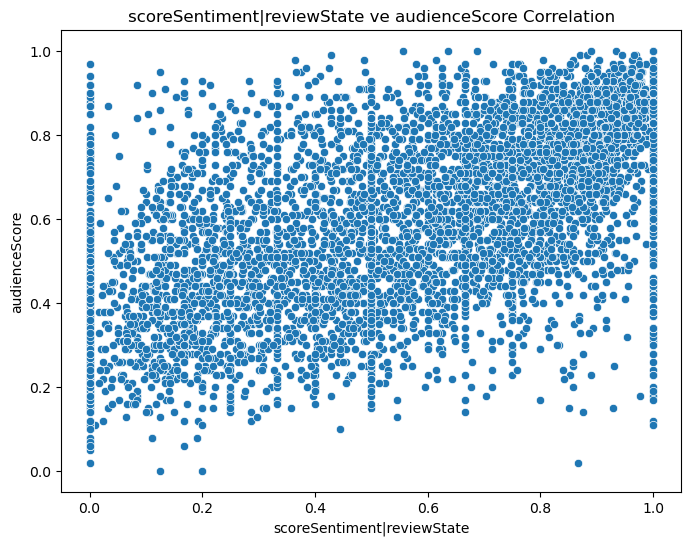

Correlation: 0.563816


In [75]:
col1 = 'scoreSentiment|reviewState'
col2 = 'audienceScore'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=before_df[col1], y=before_df[col2])

plt.title(f'{col1} ve {col2} Correlation')
plt.xlabel(col1)
plt.ylabel(col2)

plt.show()
print("Correlation: 0.563816")

### we can clearly see that there is a positive correlation between auidenceScore and scoreSentiment|reviewState

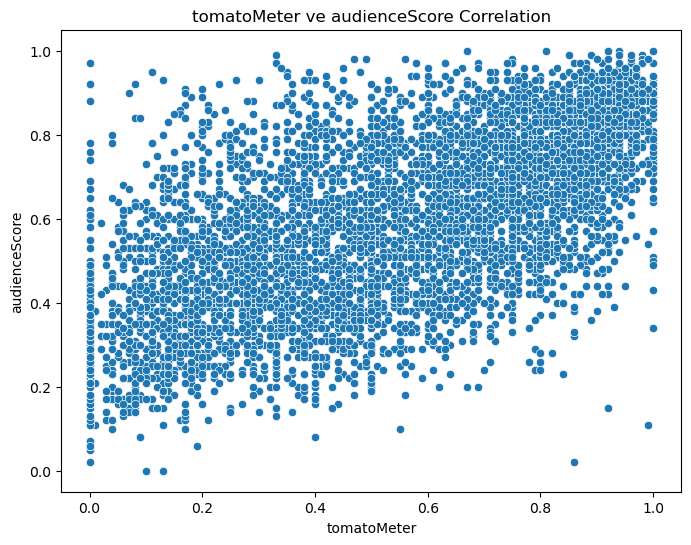

correlation : 0.628761


In [76]:
col1 = 'tomatoMeter'
col2 = 'audienceScore'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=before_df[col1], y=before_df[col2])

plt.title(f'{col1} ve {col2} Correlation')
plt.xlabel(col1)
plt.ylabel(col2)

plt.show()
print("correlation : 0.628761")

### again we can see that there is a positive correlation

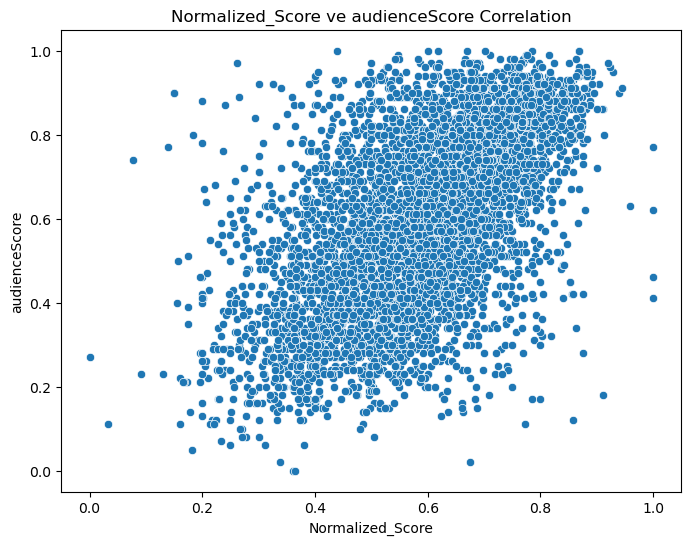

Correlation: 0.584176


In [77]:
col1 = 'Normalized_Score'
col2 = 'audienceScore'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=before_df[col1], y=before_df[col2])

plt.title(f'{col1} ve {col2} Correlation')
plt.xlabel(col1)
plt.ylabel(col2)

plt.show()
print("Correlation: 0.584176")

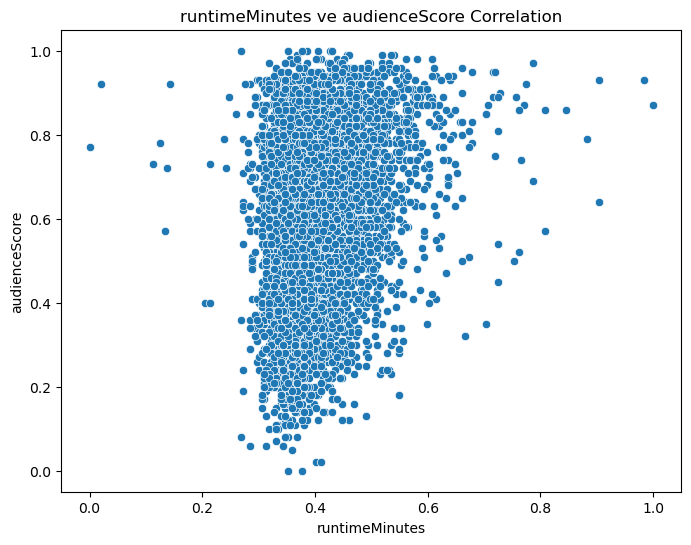

Correlation: 0.284155


In [78]:
col1 = 'runtimeMinutes'
col2 = 'audienceScore'

# Scatter plot çizin
plt.figure(figsize=(8, 6))
sns.scatterplot(x=before_df[col1], y=before_df[col2])

# Grafik başlığı ve eksen etiketlerini ekleyin
plt.title(f'{col1} ve {col2} Correlation')
plt.xlabel(col1)
plt.ylabel(col2)

# Grafikleri göster
plt.show()
print("Correlation: 0.284155")

### we have again a correlation but it is not strong as others

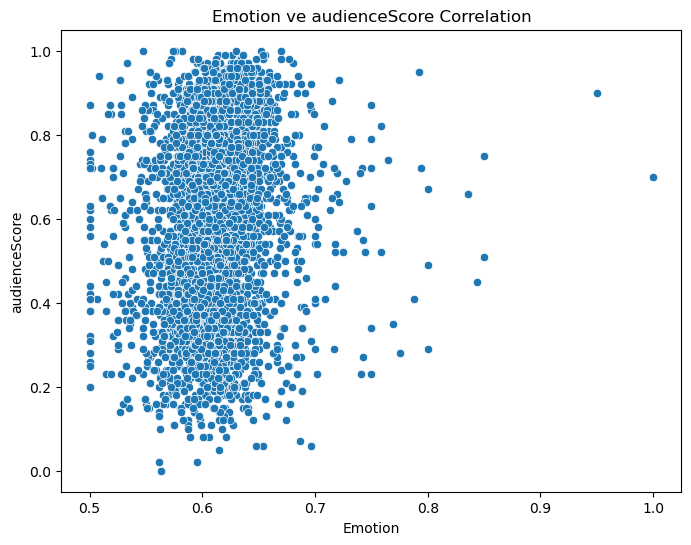

Correlation: 0.179668


In [79]:
col1 = 'Emotion'
col2 = 'audienceScore'

# Scatter plot çizin
plt.figure(figsize=(8, 6))
sns.scatterplot(x=before_df[col1], y=before_df[col2])

# Grafik başlığı ve eksen etiketlerini ekleyin
plt.title(f'{col1} ve {col2} Correlation')
plt.xlabel(col1)
plt.ylabel(col2)

# Grafikleri göster
plt.show()
print("Correlation: 0.179668")

# Clustering Analysis

### and it is the least correlated with auidenceScore which we have shown on the tables 

In [80]:
from sklearn.decomposition import PCA

### We are dropping response variable so that we can see clusterings on the graph without actual cluster label 

In [81]:
pca_df = before_df.drop("audienceScore",axis = 1)

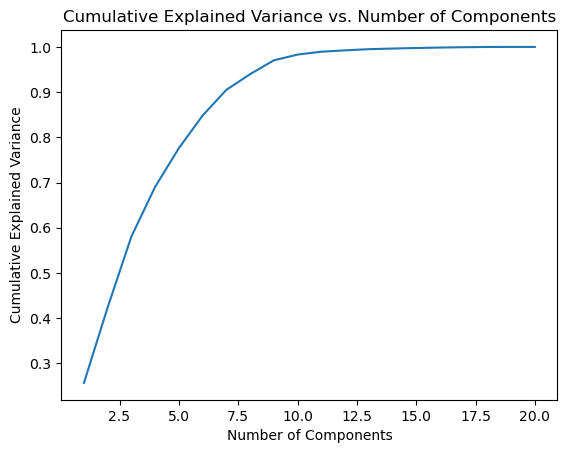

In [82]:
pca = PCA()
pca.fit(pca_df)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

### The most of the variance can be explained by 10-11 components but for visualisation we willl use only two clusters

In [83]:
pca_df = pca.fit_transform(pca_df)

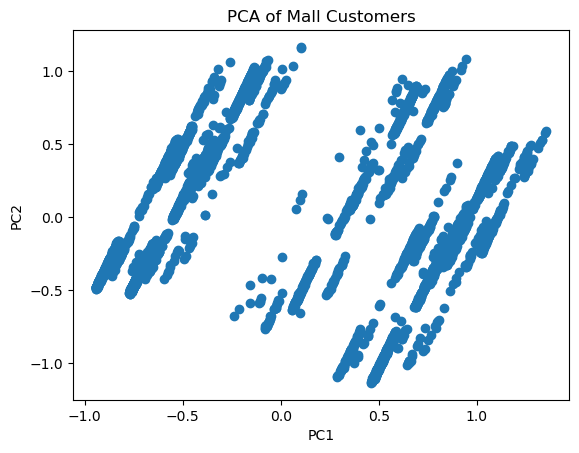

In [84]:
plt.scatter(pca_df[:, 0], pca_df[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Mall Customers')
plt.show()

### We can see a clustering around here: 

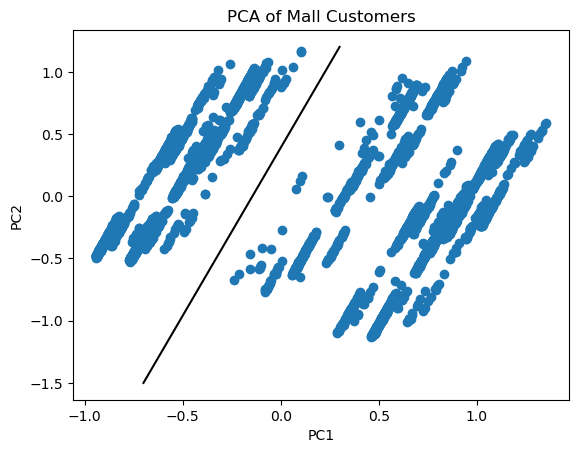

In [85]:
plt.scatter(pca_df[:, 0], pca_df[:, 1])
plt.plot([-0.7,0.3], [-1.5,1.2], label='Cluster Line',color = "black")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Mall Customers')
plt.show()

### We can say that our dataset is mainly grouped at 3 clusters for this graph, so it could be better if we grouped audience liking into 3 groups as liked -neutreal and didn't like, but for the sake of convenience and since the 2 components only manage to explain near half of the variance, we will limit our dataset for 2 categories and assume main clusetrings as the two above

### Before our classification algorithms we want to mention starting about why we choose them. Firstly we have to make classification with our data because of that our models has to be suitable for it. Secondly we believe that the best way is the way which we know. We have experience with this two classification algorithm and we believed that we can make good guesses with them thats the reaseons why we choose this two algorithm.

# kNN Classification

### now we are going to build our kNN algorithm and firstly we are shuffle and split our data for train and test data

In [86]:
knn_df = before_df
def shuffle_and_split(dataframe, train_ratio=0.7, random_state=None):

    shuffled_df = dataframe.sample(frac=1, random_state=random_state)

    train_size = int(train_ratio * len(shuffled_df))
    train_set = shuffled_df.iloc[:train_size, :]
    test_set = shuffled_df.iloc[train_size:, :]

    return train_set, test_set


Train, Test = shuffle_and_split(knn_df)

### after that we create a function which found the best k value for our knn and return the values which we predict

In [87]:
def knnFunc(X_train,y_train,X_test,y_test,title):
    
    k_values = np.arange(1, 31)
    mse_values = []
    r2_values = []
    
    for k in k_values:
        knn_model = KNeighborsRegressor(n_neighbors=k)
        knn_model.fit(X_train, y_train)

        y_pred = knn_model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_values.append(mse)
        r2_values.append(r2)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, mse_values, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.show()

    optimal_k_index = np.argmin(mse_values)
    optimal_k = k_values[optimal_k_index]
    optimal_mse = mse_values[optimal_k_index]
    optimal_r2 = r2_values[optimal_k_index]
    

    print(f'Optimal k: {optimal_k}')
    print(f'Optimal MSE: {optimal_mse}')
    print(f'R-squared for Optimal k: {optimal_r2}')
    
    optimal_knn_model = KNeighborsRegressor(n_neighbors=optimal_k)
    optimal_knn_model.fit(X_train, y_train)

    y_pred_optimal = optimal_knn_model.predict(X_test)

    return y_pred_optimal

### splitting the features and targets and using knnFunc

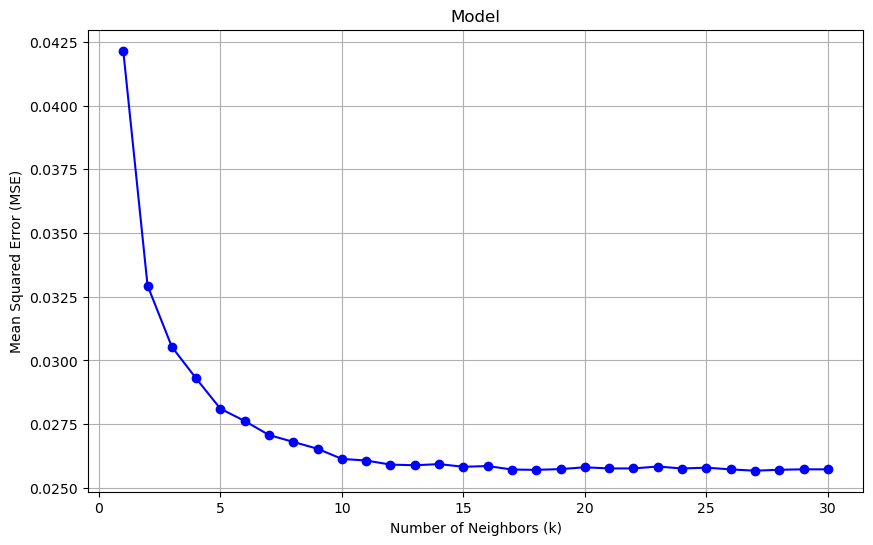

Optimal k: 27
Optimal MSE: 0.025672294173049535
R-squared for Optimal k: 0.42558474567443294


In [88]:
FeaturesTrain, TargetTrain = Train[['isTopCritic', 'scoreSentiment|reviewState', 'Normalized_Score',
       'Emotion', 'tomatoMeter', 'runtimeMinutes',
       'Normalized_Date', 'Adventure', 'Drama', 'Comedy', 'Mystery&thriller',
       'Action', 'PG-13', 'R', 'PG', 'NC-17', 'TVPG', 'TVMA', 'TV14', 'TVY7']], Train['audienceScore']

FeaturesTest, TargetTest = Test[['isTopCritic', 'scoreSentiment|reviewState', 'Normalized_Score',
       'Emotion', 'tomatoMeter', 'runtimeMinutes',
       'Normalized_Date', 'Adventure', 'Drama', 'Comedy', 'Mystery&thriller',
       'Action', 'PG-13', 'R', 'PG', 'NC-17', 'TVPG', 'TVMA', 'TV14', 'TVY7']], Test['audienceScore']

y_pred_optimal = knnFunc(FeaturesTrain,TargetTrain,FeaturesTest,TargetTest,"Model")

#### we found best k value and we have used it in our knn and made our guesses

In [89]:
Test["ourGuess"] = y_pred_optimal

In [90]:
Test['ourGuessBoolean'] = Test['ourGuess'].apply(lambda x: 1 if x > 0.55 else 0)
Test['audienceScoreBoolean'] = Test["audienceScore"].apply(lambda x: 1 if x>0.5 else 0)

In [91]:
check = Test[["audienceScoreBoolean","ourGuessBoolean"]]

### we change our normalized values to boolean values with this way we put them in to classes and we are going to check their correctness wih confusion matrix

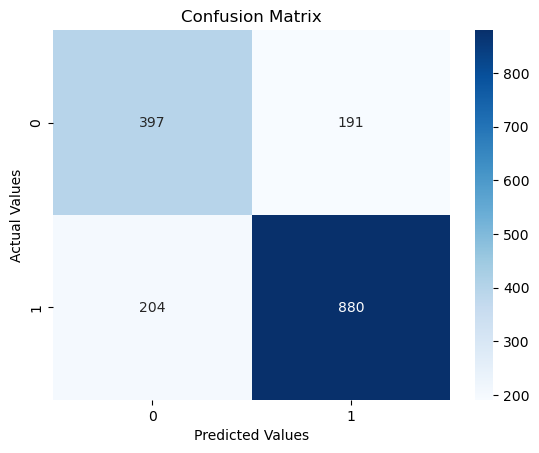

In [92]:
cm = confusion_matrix(check["audienceScoreBoolean"], check["ourGuessBoolean"])
tp = cm[1][1]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[0][0]

precision = tp / (tp + fp)
recall = tp / (tp + fn)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

### Our model accuracy : .78 precision : .84 and recall: .81

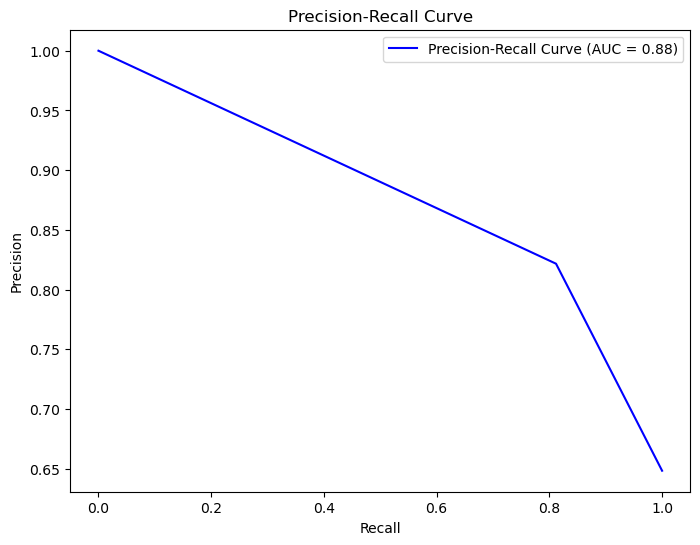

In [93]:
precision, recall, thresholds = precision_recall_curve(check["audienceScoreBoolean"], check["ourGuessBoolean"])

auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

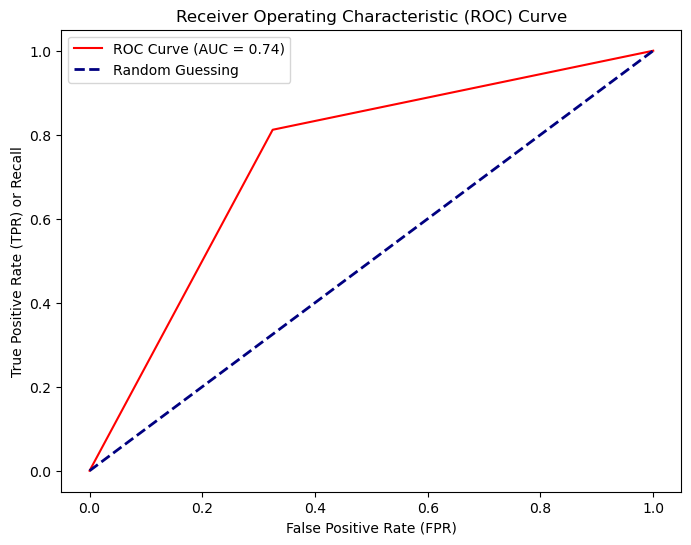

In [94]:
fpr, tpr, thresholds_roc = roc_curve(check["audienceScoreBoolean"], check["ourGuessBoolean"])

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='r')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# Logistic Regression

### Now we will go onto logistic regression but first we will drop language and old date columns

In [95]:
model_df = inner_merged.drop(columns = ["releaseDateStreaming","originalLanguage"])

### Since we want to make a classification model, we have to turn the classificating variable into categorical form
## we will say that auience liked the movie if audiencescore >0.5 and represent it as 1, didn't like if <0.5 and representing it as 0

In [96]:
model_df["audienceScore"] = model_df["audienceScore"].apply(lambda x: 1 if x>=0.5 else 0)
model_df.head()

,isTopCritic,scoreSentiment|reviewState,Normalized_Score,Emotion,audienceScore,tomatoMeter,runtimeMinutes,Normalized_Date,Adventure,Drama,...,Mystery&thriller,Action,PG-13,R,PG,NC-17,TVPG,TVMA,TV14,TVY7
id,,,,,,,,,,,,,,,,,,,,,
10000_bc,0.264957,0.094017,0.346805,0.600890,0,0.09,0.426778,0.417854,1,1,...,0,1,1,0,0,0,0,0,0,0
102_not_out,0.333333,0.555556,0.547222,0.569969,1,0.50,0.397490,0.811274,0,0,...,0,0,0,0,1,0,0,0,0,0
10_cloverfield_lane,0.232558,0.911628,0.732362,0.626670,1,0.90,0.401674,0.729932,0,0,...,1,0,1,0,0,0,0,0,0,0
10_items_or_less,0.431818,0.659091,0.659968,0.626043,1,0.63,0.309623,0.372093,0,1,...,0,0,0,1,0,0,0,0,0,0
10_minutes_gone,0.250000,0.000000,0.227679,0.587500,0,0.00,0.338912,0.858536,0,1,...,1,1,0,1,0,0,0,0,0,0


### We will shuffle and split the dataset now

In [97]:
shuffled=model_df.sample(frac = 1,random_state=1)

In [98]:
logistic_regression_model = LogisticRegression()

In [99]:
kf = KFold(n_splits=5)
kf.get_n_splits(shuffled) 

5

In [100]:
results = {} #we will put confusion matrixes for each fold

In [101]:
a = 0
for train_index, test_index in kf.split(shuffled):
    a+=1
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_LR, X_test_LR = shuffled.iloc[train_index].drop("audienceScore",axis = 1), shuffled.iloc[test_index].drop("audienceScore",axis = 1)
    Y_train_LR, Y_test_LR = shuffled.iloc[train_index]["audienceScore"], shuffled.iloc[test_index]["audienceScore"]    
    logistic_regression_model.fit(X_train_LR, Y_train_LR)
    Y_pred_LR = logistic_regression_model.predict(X_test_LR)
    results["{}".format(a)] = confusion_matrix(Y_test_LR, Y_pred_LR)

TRAIN: [1115 1116 1117 ... 5569 5570 5571] TEST: [   0    1    2 ... 1112 1113 1114]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [1115 1116 1117 ... 2227 2228 2229]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [2230 2231 2232 ... 3341 3342 3343]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [3344 3345 3346 ... 4455 4456 4457]
TRAIN: [   0    1    2 ... 4455 4456 4457] TEST: [4458 4459 4460 ... 5569 5570 5571]


In [102]:
results

{'1': array([[205, 164],
        [ 88, 658]]),
 '2': array([[220, 143],
        [109, 643]]),
 '3': array([[215, 139],
        [100, 660]]),
 '4': array([[213, 152],
        [ 83, 666]]),
 '5': array([[213, 153],
        [109, 639]])}

In [103]:
final_confusion_matrix = np.zeros((2,2))
final_confusion_matrix
for cm_LR in results.values():
    final_confusion_matrix[0][0] +=cm_LR[0][0]
    final_confusion_matrix[1][0] +=cm_LR[1][0] 
    final_confusion_matrix[1][1] +=cm_LR[1][1] 
    final_confusion_matrix[0][1] +=cm_LR[0][1]
final_confusion_matrix=final_confusion_matrix.astype(int)

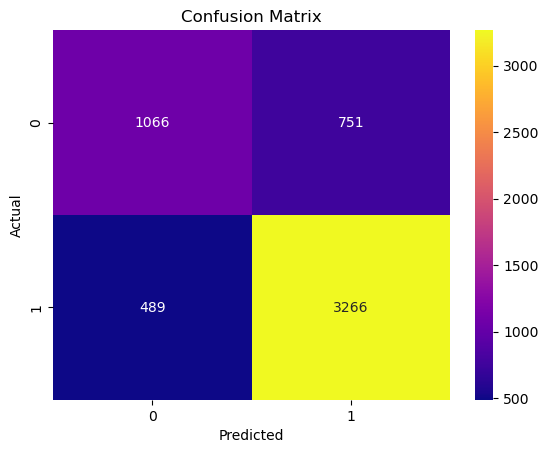

In [104]:
sns.heatmap(final_confusion_matrix, annot=True, fmt="d", cmap="plasma",
                xticklabels=np.unique(Y_test_LR),
                yticklabels=np.unique(Y_test_LR))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Our model accuracy : .79 precision : .81 and recall: .87

### Our model makes correct classifiying 4 out of 5 times
### we are again correctly classifiying as positive 4 out of 5 times
### our model especially good at classifiying actual positives. We can proudly say that we can predict nearly 9 films out of 10 that will be a success among the audience

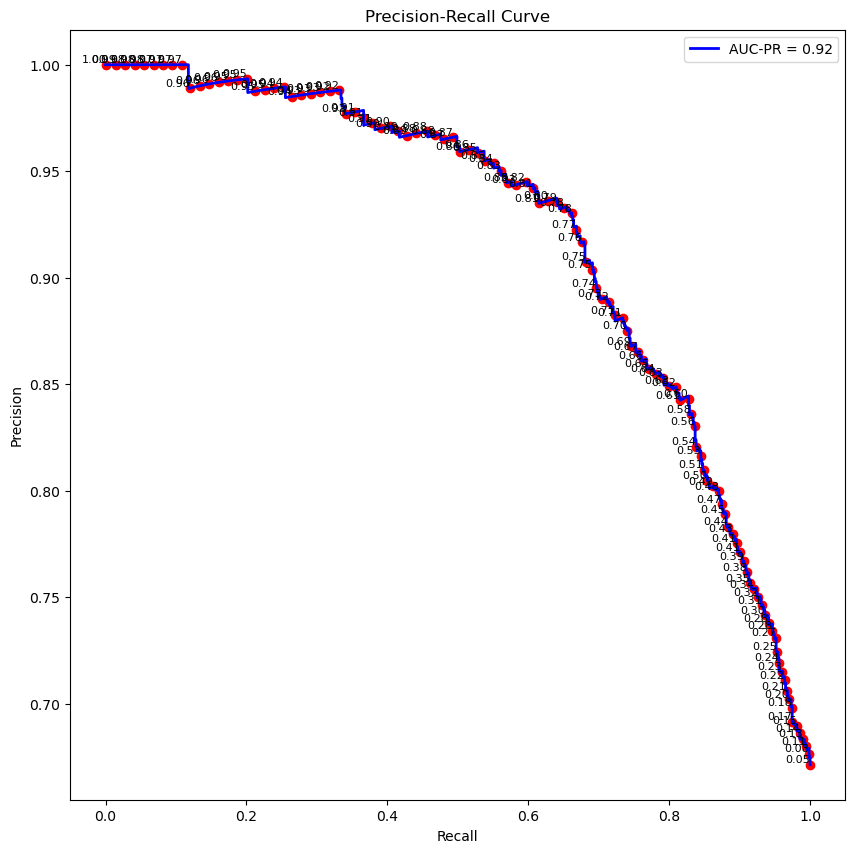

In [105]:
LR_probabilities = logistic_regression_model.predict_proba(X_test_LR)[:, 1]
precision_LR, recall_LR, thresholds_LR = precision_recall_curve(Y_test_LR, LR_probabilities)

auc_pr_LR = average_precision_score(Y_test_LR, LR_probabilities)

plt.figure(figsize=(10, 10))
plt.plot(recall_LR, precision_LR, color='blue', lw=2, label=f'AUC-PR = {auc_pr_LR:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

n = 10 #for plotting every nth treshold for the sake of graph simplicity
for i,threshold in enumerate(thresholds_LR):
    if i%10!=0: continue
    index = next(i for i, t in enumerate(thresholds_LR) if t >= threshold)
    plt.scatter(recall_LR[index], precision_LR[index], color='red', marker='o', label=f'{threshold:.2f}')
    plt.text(recall_LR[index], precision_LR[index], f'{threshold:.2f}', fontsize=8, verticalalignment='bottom', horizontalalignment='right')

plt.show()

### This model mainly aims to not miss a film if it is going to be a hit. So recall seems to be more important for us. For that reason, we should choose around 0.46,47 as treshold values so that we have a high recall and a decent precision rate

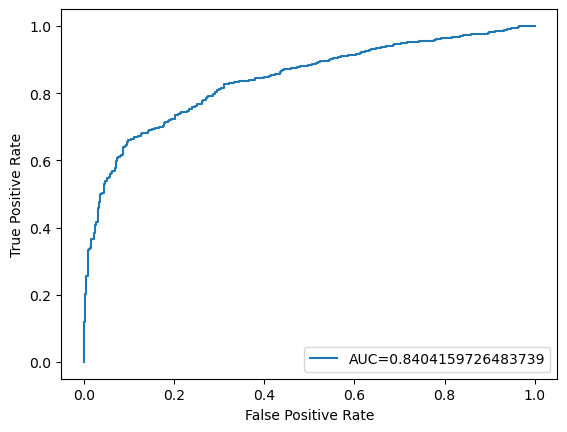

In [106]:
fpr, tpr, _ = metrics.roc_curve(Y_test_LR, LR_probabilities)
auc = metrics.roc_auc_score(Y_test_LR, LR_probabilities)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Our ROC curve says that altough model works fine, we might still have a bit noise, I think that is mostly because of low performance on our nlp model, altough it does a good job on cathcing text sentiment for easy texts, it struggles with a bit more complicated critics' review texts. I this context, we can correclty detect 85 times out of 100 with 35 percent false positive rate

# Comparing the models:


We are analyzing the performance of two classification models, namely KNN (k-Nearest Neighbors) and Logistic Regression. The evaluation metrics are accuracy, precision, recall, precision-recall AUC, and ROC AUC.

KNN Classification:
Accuracy: 78%

The KNN model achieved a commendable accuracy of 78%, indicating the overall correctness of predictions.
Precision: 84%

Precision measures the model's ability to correctly identify positive instances among the predicted positives. The KNN model achieved a precision of 84%, indicating a low rate of false positives.
Recall: 81%

Recall measures the model's ability to identify all relevant instances among the actual positives. The KNN model achieved a recall of 81%, reflecting its effectiveness in capturing a substantial proportion of positive instances.
Precision-Recall AUC: 89%

The Precision-Recall AUC is a crucial metric that evaluates the trade-off between precision and recall across different classification thresholds. The KNN model achieved a score of 89%, suggesting a good balance between precision and recall.
ROC AUC: 75%

The ROC AUC evaluates the model's ability to discriminate between positive and negative instances across different classification thresholds. The KNN model achieved a score of 75%, indicating moderate discrimination performance.

Logistic Regression:
Accuracy: 79%

The logistic regression model demonstrated a slightly higher accuracy of 79%, showcasing its ability to make correct predictions.
Precision: 81%

With a precision of 81%, logistic regression displayed a reasonable ability to correctly identify positive instances while minimizing false positives.
Recall: 87%

Logistic regression outperformed KNN in terms of recall, achieving a score of 87%, indicating its effectiveness in capturing a higher proportion of relevant instances.
Precision-Recall AUC: 92%

The logistic regression model excelled in the Precision-Recall AUC, achieving a score of 92%, suggesting a superior balance between precision and recall.
ROC AUC: 84%

Logistic regression demonstrated strong discrimination performance with a ROC AUC of 84%, indicating its ability to distinguish between positive and negative instances effectively.
Conclusion:
In summary, both KNN and logistic regression models have shown decent performances, with each model are better in different
 aspects. While KNN demonstrated a slightly lower accuracy and recall, it showed a good balance between precision and recall, 
as indicated by the Precision-Recall AUC. On the other hand, logistic regression showed higher accuracy, recall, and Precision-Recall AUC, 
making it a strong contender for tasks where maximizing recall is crucial. The choice between the two models should be decided by the specific 
requirements and priorities of the classification task.

We want higher precision for this task, because if we use our model to predict a good movie and make investment on that, or even for a viewer, we would like to choose good movie, without false positives to make false investments on or watching a bad one thinking it was good. So for this task knn classifier would be a better evaluator since it ahs a better precision value that logistic regression